In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

import spacy

In [2]:
mails = pd.read_csv('CEAS_08.csv')
print(mails.head(10))

sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                 Michael Parker <ivqrnai@pobox.com>   
4  Gretchen Suggs <externalsep1@loanofficertool.com>   
5  Caroline Aragon <dwthaidomainnamesm@thaidomain...   
6    Replica Watches <jhorton@thebakercompanies.com>   
7             Daily Top 10 <acidirev_1972@tcwpg.com>   
8                  qydlqcws-iacfym@issues.apache.org   
9      Daily Top 10 <orn|dent_1973@musicaedischi.it>   

                                         receiver  \
0                     user4@gvc.ceas-challenge.cc   
1                   user2.2@gvc.ceas-challenge.cc   
2                   user2.9@gvc.ceas-challenge.cc   
3  SpamAssassin Dev <xrh@spamassassin.apache.org>   
4                   user2.2@gvc.ceas-challenge.cc   
5                user7-ext5@gvc.ceas-challenge.cc   
6                  user2.10@gvc.ceas-challenge.cc   
7    

In [3]:
duplicates = mails.duplicated(subset=['subject', 'sender'], keep=False)

In [4]:
print(mails.isnull().sum().sort_values())
mails.dropna(subset=['subject'], inplace=True)

sender        0
date          0
body          0
label         0
urls          0
subject      28
receiver    462
dtype: int64


In [5]:
print(mails['sender'].values)

['Young Esposito <Young@iworld.de>' "Mok <ipline's1983@icable.ph>"
 'Daily Top 10 <Karmandeep-opengevl@universalnet.psi.br>' ...
 'Abhijit Vyas <xpojhbz@gmail.com>'
 'Joseph Brennan <vupzesm@columbia.edu>'
 'Christian Heimes <wluhe@cheimes.de>']


In [6]:
def strip_for_mail(sender):
    start_symbol = '<'
    end_symbol = '>'
    if start_symbol in sender:
        start_index = sender.index(start_symbol) + 1
        end_index = sender.index(end_symbol)
        output = sender[start_index:end_index]
        return output
    else:
        return sender

print(strip_for_mail('Young Esposito <Young@iworld.de>'))

mails['sender_mail'] = mails['sender'].apply(strip_for_mail)
print(mails['sender_mail'].head(100))




Young@iworld.de
0                             Young@iworld.de
1                      ipline's1983@icable.ph
2     Karmandeep-opengevl@universalnet.psi.br
3                           ivqrnai@pobox.com
4            externalsep1@loanofficertool.com
                       ...                   
95                           liivp@python.org
96                       ppcwedbyff@gmail.com
97                        xycn-vtnhz@perl.org
98                   qgzon.djsmosok@gmail.com
99      vqznddhdkax_04446187@yourvoice.net.nz
Name: sender_mail, Length: 100, dtype: object


In [7]:
mails = mails[['sender_mail', 'subject', 'body', 'urls', 'label']]
mails.columns = ['sender_mail', 'subject', 'body', 'contain_urls', 'is_phishing']

In [8]:
# Smaller dataframe for easier computing
mails_small = mails.head(100)

In [9]:
text_example = mails_small.iloc[2]['body']
print(text_example)

>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= >THE DAILY TOP 10 >from CNN.com >Top videos and stories as of: Aug  1, 2008  3:58 PM EDT >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= TOP 10 VIDEOS 1. MONTAUK 'MONSTER' http://www.cnn.com/video/partners/email/index.html?url=/video/us/2008/07/31/moos.montauk.monster.cnn Is it a devil dog? Is it a turtle? Is it the Montauk Monster? CNN's Jeanne Moos asks, "what is this thing?" 2. RACY PHOTOS OF TODDLER'S MOM http://www.cnn.com/video/partners/email/index.html?url=/video/crime/2008/07/31/ng.racy.photos.cnn 3. NEWS OF THE ABSURD EPISODE 54 http://www.cnn.com/video/partners/email/index.html?url=/video/podcasts/absurd/site/2008/08/01/nota.episode.54.cnn 4. POLICE BEATING DISPUTE http://www.cnn.com/video/partners/email/index.html?url=/video/us/2008/07/31/levs.police.video.cnn 5. MOM PLEADS FOR GIRL'S RETURN http://www.cnn.com/video/partners/email/index.html?url=/video/crime/2008/08/01/hill.boss.reigh.plea.cnn 6. DEF

In [12]:
def count_tuples(t):
    return len(t)

mails_small['lemmas'] = mails_small['body'].apply(get_lemmas)
mails_small['lemmas_len'] = mails_small['lemmas'].apply(count_tuples)

mails_small['entities'] = mails_small['body'].apply(get_ents)
mails_small['entities_len'] = mails_small['entities'].apply(count_tuples)

mails_small['pos'] = mails_small['body'].apply(get_pos)
mails_small['pos_len'] = mails_small['pos'].apply(count_tuples)

print(mails_small.head(3))

sender_mail                    subject  \
0                          Young@iworld.de  Never agree to be a loser   
1                   ipline's1983@icable.ph     Befriend Jenna Jameson   
2  Karmandeep-opengevl@universalnet.psi.br       CNN.com Daily Top 10   

                                                body  contain_urls  \
0  Buck up, your troubles caused by small dimensi...             1   
1  \nUpgrade your sex and pleasures with these te...             1   
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...             1   

   is_phishing                                             lemmas  lemmas_len  \
0            1  [Buck, trouble, cause, small, dimension, soon,...          19   
1            1                [upgrade, sex, pleasure, technique]           4   
2            1  [DAILY, TOP, video, story, Aug, PM, EDT, VIDEO...         144   

                                            entities  entities_len  \
0                     [(Buck, PERSON), (Nazi, NORP)]          

In [10]:
# Set up spaCy
nlp = spacy.load('en_core_web_lg')

stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [11]:
def not_stopword_and_is_alpha(s):
    return s.isalpha() and s not in stopwords


def get_lemmas(s):
    doc = nlp(s)
    output = [token.lemma_ for token in doc
                        if not_stopword_and_is_alpha(token.lemma_)]
    return output


def get_ents(s):
    doc = nlp(s)
    output = [(ent.text, ent.label_) for ent in doc.ents
                                    if not_stopword_and_is_alpha(ent.text)]
    return output


def get_pos(s):
    doc = nlp(s)
    output = [(token.text, token.pos_) for token in doc
                                    if not_stopword_and_is_alpha(token.text)]
    return output

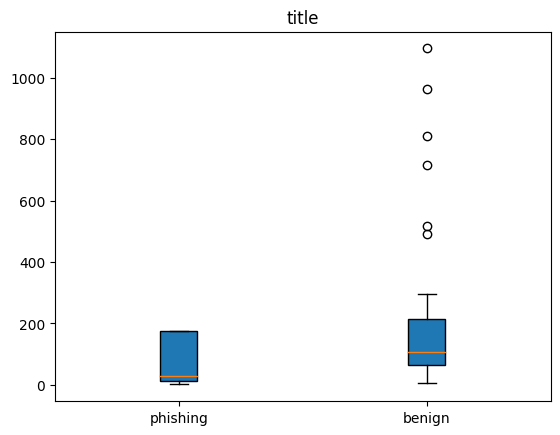

In [15]:
plt.style.use('default')

labels = ['phishing', 'benign']
data = [
    phishing_rows['pos_len'],
    benign_rows['pos_len'],
]

fig, ax = plt.subplots()
#ax.scatter(mails_small['pos_len'], mails_small['is_phishing'])
ax.boxplot(data,
            vert=True,
            patch_artist=True,
            labels=labels)
ax.set_title('title')
plt.show()

In [13]:
phishing_rows = mails_small.loc[mails_small['is_phishing'] == 1][['sender_mail', 'pos_len']]
benign_rows = mails_small.loc[mails_small['is_phishing'] == 0][['sender_mail', 'pos_len']]